In [1]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
#from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
import dsp_lib

In [2]:
from scipy.signal import butter, filtfilt
import os
from array import array

In [3]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

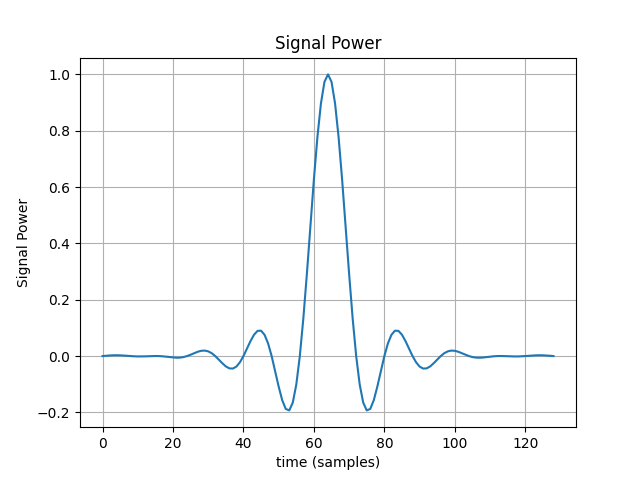

1032000


In [4]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = dsp_lib.gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 1000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = dsp_lib.gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')
dsp_lib.save_cmplx_sig(s_qpsk[::8], 'qpsk_constellation.dat', 'int16')
print(len(s_qpsk))

In [5]:
mixed_qpsk = dsp_lib.add_freq(qpsk_rc, 0.5)
mixed_qpsk = dsp_lib.add_phase(mixed_qpsk, 0.3)

In [6]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.566827744752411-1.5547527722745778j)
4.566827744752411
4.591968507990069
7135.719668587689


129
1
8
(4.288251108865568-1.3809874696460682j)
4.288251108865568
4.348242599105621
7535.688097701762


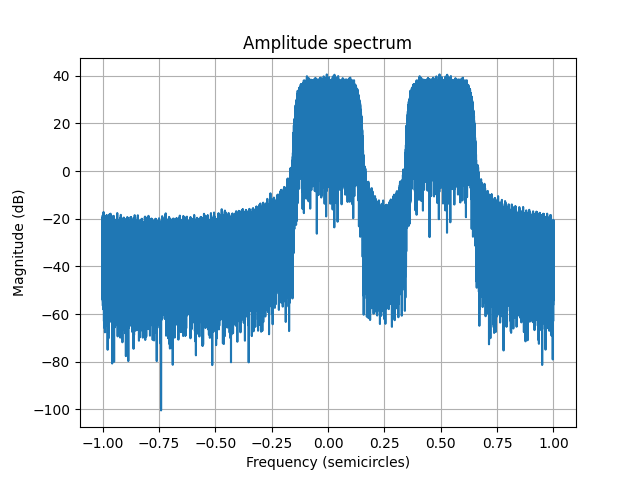

array([[-53.56101971],
       [-25.85745194],
       [-29.16479129],
       ...,
       [-20.47591903],
       [-32.15354691],
       [-27.33548521]])

In [7]:
print(N)
print(Fs)
print(T_symb)
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = dsp_lib.add_freq(qpsk_rrc, 0.5)
mixed_qpsk = dsp_lib.add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
max(two_sigs)
two_sigs_upsc = upscale_to_i16(two_sigs)
dsp_lib.save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float.bin', 'float64')
dsp_lib.save_cmplx_sig(two_sigs_upsc, "qpsk_rrc_int16.bin", 'int16')
max(two_sigs_upsc)
dsp_lib.plot_spectrum(two_sigs_upsc, 10)

129
1
8
(4.288251108865568-1.3809874696460682j)
4.288251108865568
4.348242599105621
7535.688097701762
sig len = 1032000


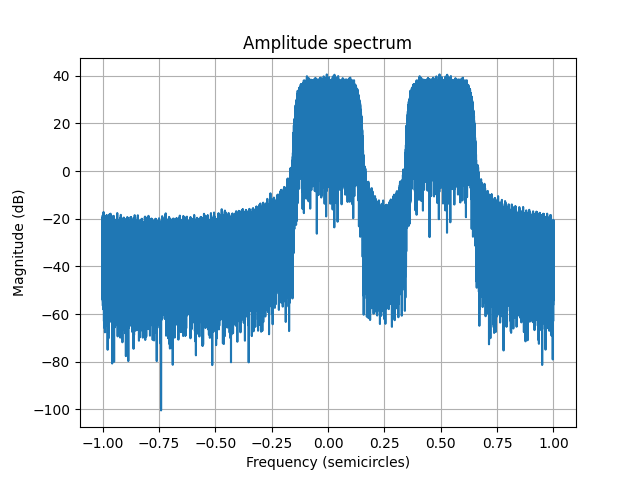

[18553.14317032 -6679.9001069j   6528.16109996 +3218.65604586j
 -3303.66174408-10497.01753506j 11166.77626756-20183.47175667j
 20457.4253062  -5346.95014945j  6024.11119277 +3687.65292245j
 -2233.34592664 -9660.26586921j 10389.20872361-16936.30313008j
 17413.53918991 -4606.09986713j  5479.50630857 +2829.9158764j ]


In [8]:
print(N)
print(Fs)
print(T_symb)
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = dsp_lib.add_freq(qpsk_rrc, 0.5)
mixed_qpsk = dsp_lib.add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
print(f"sig len = {len(two_sigs_upsc)}")
dsp_lib.save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float64.bin', 'float64')
dsp_lib.save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float32.bin', 'float32')
max(two_sigs_upsc)
dsp_lib.plot_spectrum(two_sigs_upsc, 10)
print(two_sigs_upsc[:10])

In [9]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])
print(s_rrc)
print(qpsk_rrc_rrc[:10])
print(qpsk_rrc_rrc[len(qpsk_rrc_rrc) - 10::])
# samples_32 = dsp_lib.read_signal('qpsk_rrc_float32.bin', 'float32')
# sig32 = dsp_lib.make_cmplx_sig(samples_32)
# print(sig32[:10])

[18553.14317032 -6679.9001069j   6528.16109996 +3218.65604586j
 -3303.66174408-10497.01753506j 11166.77626756-20183.47175667j
 20457.4253062  -5346.95014945j  6024.11119277 +3687.65292245j
 -2233.34592664 -9660.26586921j 10389.20872361-16936.30313008j
 17413.53918991 -4606.09986713j  5479.50630857 +2829.9158764j ]
[-5.27526056e-03 -3.99102742e-03 -1.64842729e-03  1.29551186e-03
  4.20829446e-03  6.41713384e-03  7.36294421e-03  6.73849224e-03
  4.57739857e-03  1.26984331e-03 -2.50378491e-03 -5.91158303e-03
 -8.15394430e-03 -8.65281056e-03 -7.20253053e-03 -4.04416717e-03
  1.59973235e-04  4.45338056e-03  7.79222114e-03  9.28996172e-03
  8.44532739e-03  5.29838667e-03  4.71398168e-04 -4.92610836e-03
 -9.51895698e-03 -1.19753744e-02 -1.13400852e-02 -7.31607595e-03
 -4.23543130e-04  8.01507220e-03  1.60811386e-02  2.16328990e-02
  2.27812262e-02  1.83734040e-02  8.37737184e-03 -5.93206756e-03
 -2.20523040e-02 -3.66153950e-02 -4.59937904e-02 -4.70527982e-02
 -3.79107833e-02 -1.85494904e-02  

In [10]:
print(qpsk_rrc_rrc[:10])

[44104.40763982-30680.05920562j 52721.62344835-37244.36259844j
 60084.53526512-43151.19616736j 65657.56012423-48136.41480799j
 69012.5624409 -52334.16587284j 70189.88069087-56070.821581j
 69505.43904816-59506.48600093j 67262.42352774-62754.73794751j
 63883.05952914-66021.64289078j 60019.58671332-69389.05430659j]


[18553.14317032 -6679.9001069j   6528.16109996 +3218.65604586j
 -3303.66174408-10497.01753506j 11166.77626756-20183.47175667j
 20457.4253062  -5346.95014945j  6024.11119277 +3687.65292245j
 -2233.34592664 -9660.26586921j 10389.20872361-16936.30313008j
 17413.53918991 -4606.09986713j  5479.50630857 +2829.9158764j ]
(118163.53563764958+765.0014080340025j)
118163.53563764958
118348.5939753948
0.27686851950951274


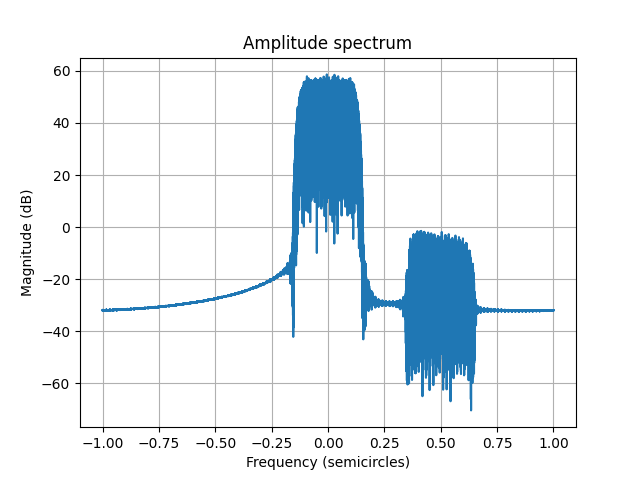

array([[-31.95259972],
       [-32.04772816],
       [-32.014838  ],
       ...,
       [-31.81539483],
       [-31.90310201],
       [-31.90128757]])

In [11]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])

two_sigs_upsc_i16 = upscale_to_i16(qpsk_rrc_rrc)
dsp_lib.save_cmplx_sig(two_sigs_upsc_i16, 'qpsk_rrc_rrc_int16_.bin', 'int16')

dsp_lib.plot_spectrum(qpsk_rrc_rrc, 1)


(1.95332457732921+1.0773422947881874j)
1.95332457732921
1.95332457732921
16774.98987126987


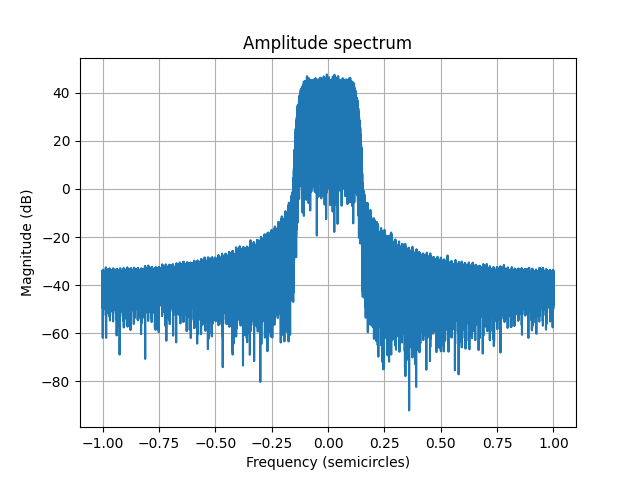

array([[-40.02542852],
       [-35.99830865],
       [-37.13021501],
       ...,
       [-41.09597372],
       [-43.07607385],
       [-42.51551693]])

In [12]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
dsp_lib.plot_spectrum(qpsk_upsc, 2)

In [13]:
dsp_lib.save_cmplx_sig(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin', 'int16')

In [14]:
dsp_lib.save_cmplx_sig(s_rrc, 'rrc_filter.bin', 'float32')